Dataset with students data extracted from Unir archive.  
Geodataframes extracted from the openlibraries https://datosabiertos.esri.co/ and https://sites.google.com/site/seriescol/shapes

# Libraries and datasets loading

In [59]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Default plot size is set.
plt.rcParams['figure.figsize'] = [15, 15]

# Geodataframes and dataset are loaded.
gdf_mun = gpd.read_file('mpio.shp')
gdf_dep = gpd.read_file('depto.shp')

df_uni = pd.read_csv('dataset.csv')

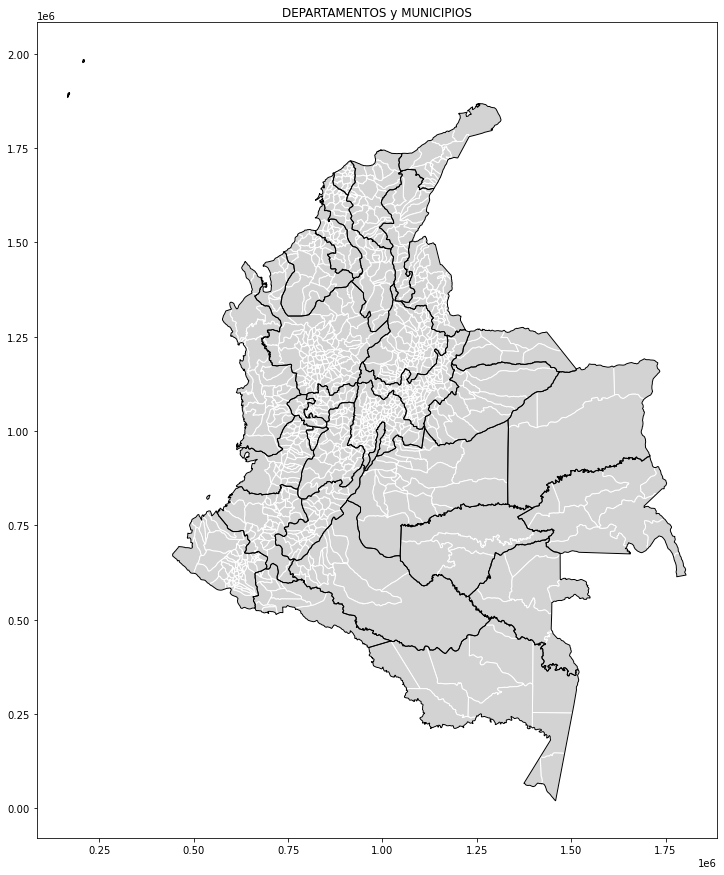

In [21]:
# To check the Geodataframes, we plot the Departments in the Country.
fig, ax = plt.subplots()
gdf_mun.plot(color='lightgrey', edgecolor='white', ax=ax)
gdf_dep.plot(color='none', edgecolor='black', ax=ax)
plt.title("DEPARTAMENTOS y MUNICIPIOS")
plt.show()

# 1.-  Preparing the merging column "DEPARTAMENTO"

In [23]:
# Rename Departament column to be the same as df_university
gdf_dep = gdf_dep.rename(columns={'NOMBRE_DPT': 'DEPARTAMENTO'})

In [24]:
# Departments in df_uni, but not in gdf_dep
uni_not_dep = df_uni.merge(gdf_dep, how = 'outer' ,indicator=True, on='DEPARTAMENTO').loc[lambda x : x['_merge']=='left_only']

uni_not_dep = uni_not_dep['DEPARTAMENTO'].to_list()
print (set(uni_not_dep))

{'OTRO PAIS', 'BOGOTA D.C', 'GUAJIRA', 'SAN ANDRES Y PROVIDENCIA'}


In [25]:
# Departments in gdf_dep, but not in df_uni
dep_not_uni = gdf_dep.merge(df_uni, how = 'outer' ,indicator=True, on='DEPARTAMENTO').loc[lambda x : x['_merge']=='left_only']

dep_not_uni = dep_not_uni['DEPARTAMENTO'].to_list()
print (set(dep_not_uni))

{'ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA', 'VAUPES', 'GUAINIA', 'VICHADA', 'LA GUAJIRA', 'ARAUCA', 'SANTAFE DE BOGOTA D.C'}


In [26]:
# Replace the names that are different in gdf_dep
gdf_dep = gdf_dep.replace(to_replace='ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA', value='SAN ANDRES Y PROVIDENCIA', regex=True)
gdf_dep = gdf_dep.replace(to_replace='SANTAFE DE BOGOTA D.C', value='BOGOTA D.C', regex=True)
gdf_dep = gdf_dep.replace(to_replace='LA GUAJIRA', value='GUAJIRA', regex=True)

In [27]:
# Check again departments in df_uni, but not in gdf_dep
uni_not_dep = df_uni.merge(gdf_dep, how = 'outer' ,indicator=True, on='DEPARTAMENTO').loc[lambda x : x['_merge']=='left_only']

uni_not_dep = uni_not_dep['DEPARTAMENTO'].to_list()
print (set(uni_not_dep))

{'OTRO PAIS'}


Once the merging column is renamed to have the same name in both the dataframe and the geodataframe ('DEPARTAMENTO'), and there are no differences from their department names (just 'Otro pais', which is considered as outlier rows), they are prepared to be merged.

# 2.-  Dataframe and Geodataframe merge (df_uni and gdf_dep)

From the University dataframe (df_uni) we can get the following frequencies or mean values in order to be merged with the geodataframe (gdf_dep)

In [28]:
# The enriched geodataframe will be called 'geodata'
# Cases frequencies along the Departments.
cases_fq = df_uni['DEPARTAMENTO'].value_counts()     # Series object of dataset frequency.

cases_fq = cases_fq.to_frame()                     # Convert series to dataframe.
cases_fq = cases_fq.rename({'DEPARTAMENTO': 'Cases_Frequency'}, axis='columns')
cases_fq['DEPARTAMENTO'] = cases_fq.index

geodata = gdf_dep.merge(cases_fq, on='DEPARTAMENTO')  # Merge frequencies with geodataframe.

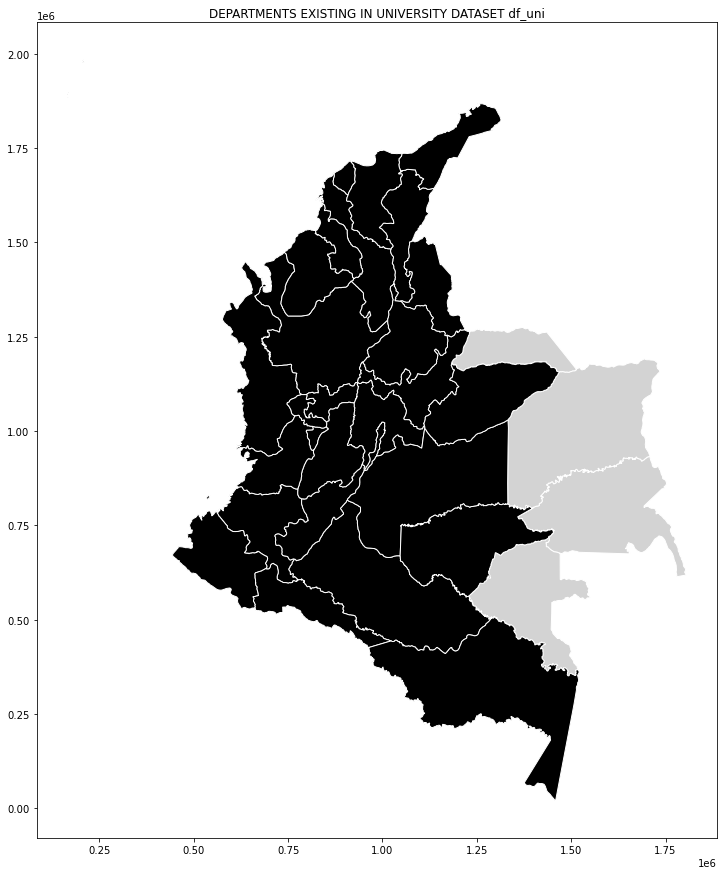

In [29]:
# Plot the municipalities that appear in the dataset.
fig, ax = plt.subplots()
gdf_dep.plot(color='lightgrey', edgecolor='white', ax=ax)
geodata.plot(color='black', edgecolor='white', ax=ax)
plt.title("DEPARTMENTS EXISTING IN UNIVERSITY DATASET df_uni")
plt.show()

Departments in grey corresponds to the ones that do not appear in the University dataset df_uni, which are Vichada, Arauca, Vaupes and Guainia.

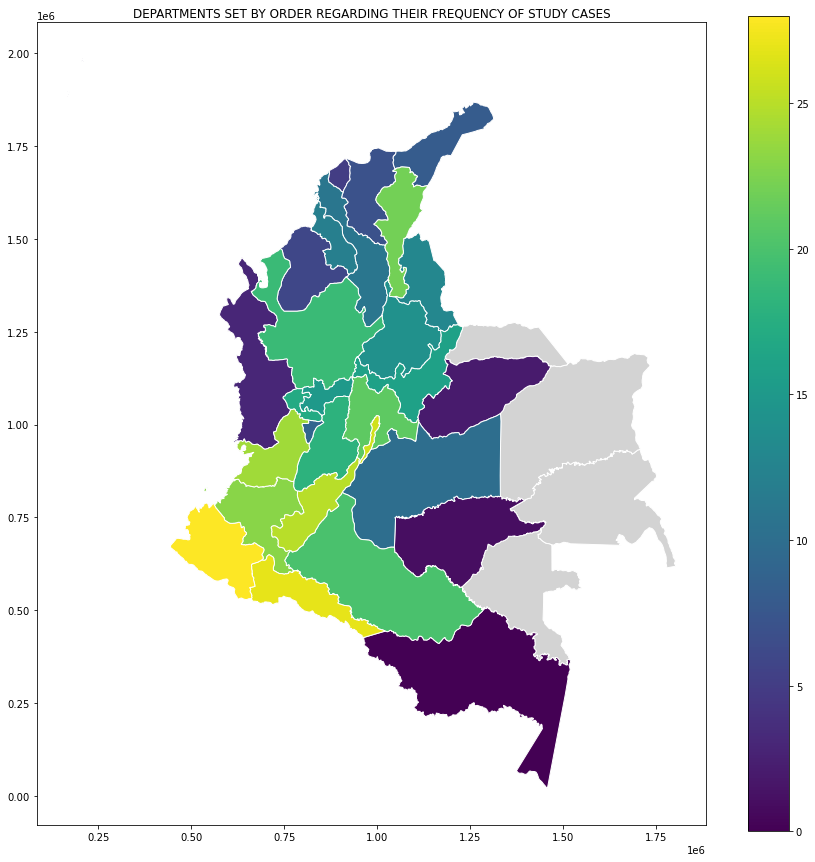

In [30]:
# Plot frequency of df_uni cases by departments
# Because the frequency of studies is very unbalanced they are ordered one by one by its frequency value

geodata = geodata.sort_values('Cases_Frequency')
geodata['Cases_Order_Value'] = np.arange(len(geodata))

fig, ax = plt.subplots()
gdf_dep.plot(color='lightgrey', edgecolor='white', ax=ax)
geodata.plot(column='Cases_Order_Value', edgecolor='white', legend=True, ax=ax)
plt.title("DEPARTMENTS SET BY ORDER REGARDING THEIR FREQUENCY OF STUDY CASES")
plt.show()

Yellow department is the one with more case studies, which corresponds to Nariño, where Pasto is located.

In [34]:
# We create a university dataset grouped by Departments, which qualifications are collapsed into mean values
df_uni_mean = df_uni.groupby('DEPARTAMENTO').mean()

# Merge collapsed university dataset with geodataframe.
geodata = geodata.merge(df_uni_mean, on='DEPARTAMENTO')  

# 3.- Visualize University data on map

In [43]:
def plot_map (course, cmap):
    fig, ax = plt.subplots()
    gdf_dep.plot(color='lightgrey', edgecolor='white', ax=ax)
    geodata.plot(column=course, cmap=cmap, edgecolor='white', legend=True, ax=ax)
    plt.title(course + " - MEAN SCORE BY DEPARTMENT")
    plt.savefig("./university_values/" + course + ".jpg")

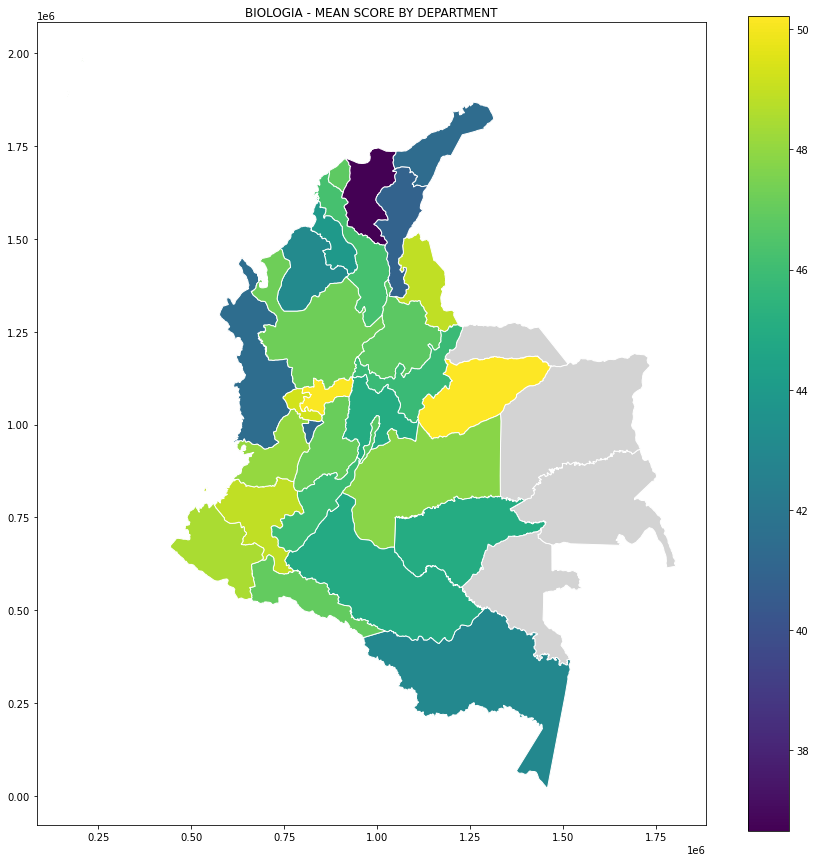

In [44]:
plot_map('BIOLOGIA', 'viridis')

In [50]:
cols = df_uni.columns 

# Numeric columns
num_cols =  list(df_uni._get_numeric_data().columns) 

non_courses=['NUMERO','ESTRATO','EDAD','INGRESO_FAMILIAR','ULT_SEMESTRE_CURSADO']
for item in non_courses:
    num_cols.remove(item)
    
courses = num_cols

<ipython-input-43-7f74845c2a47>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


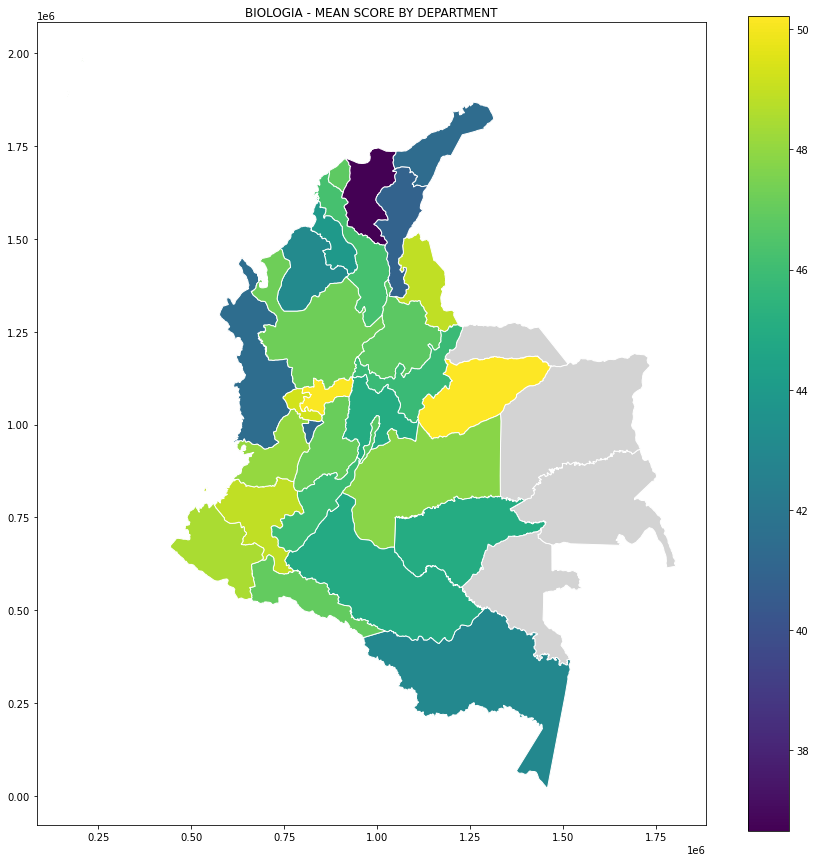

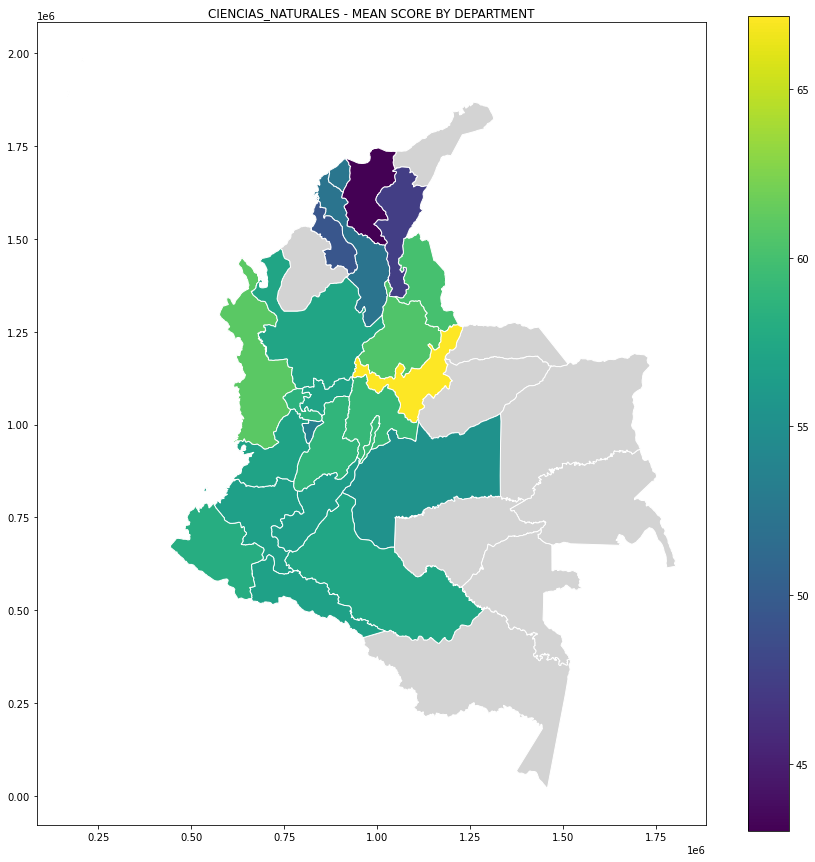

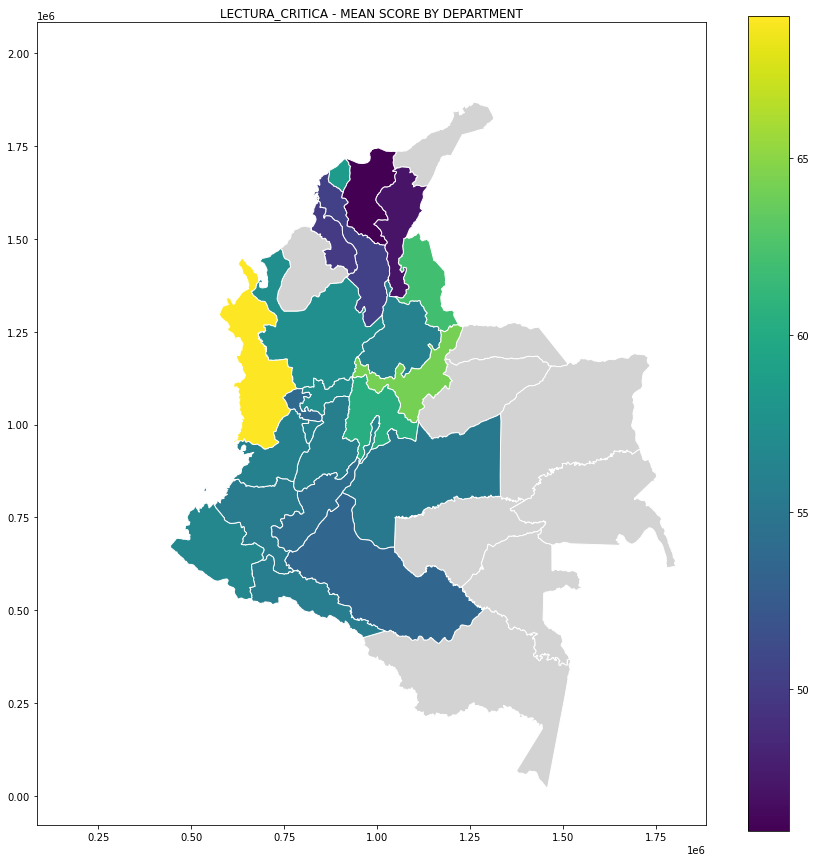

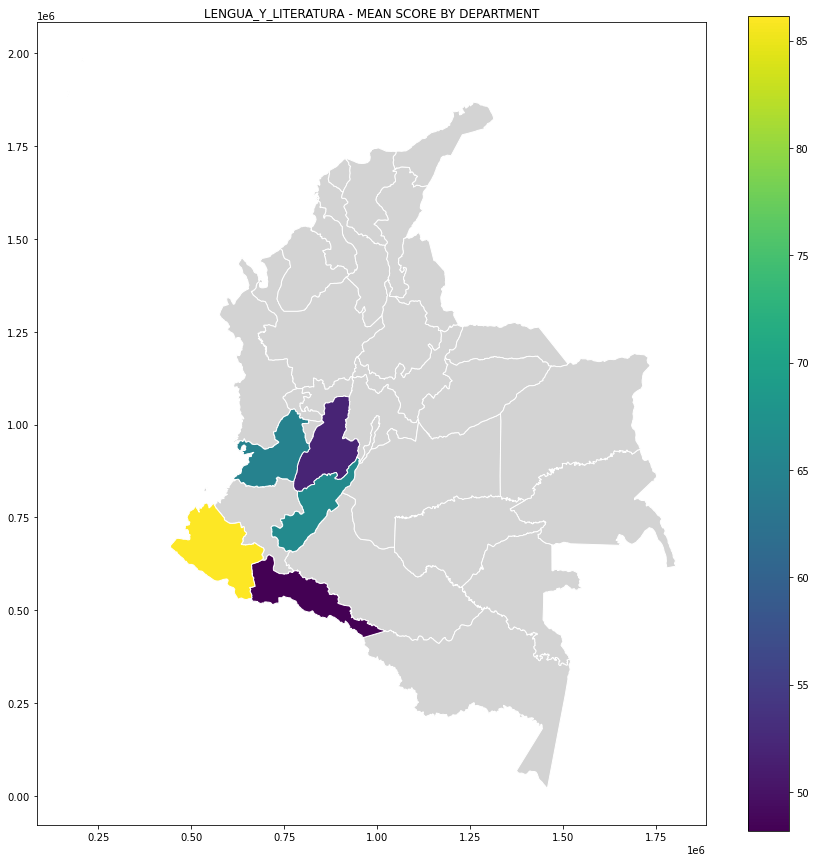

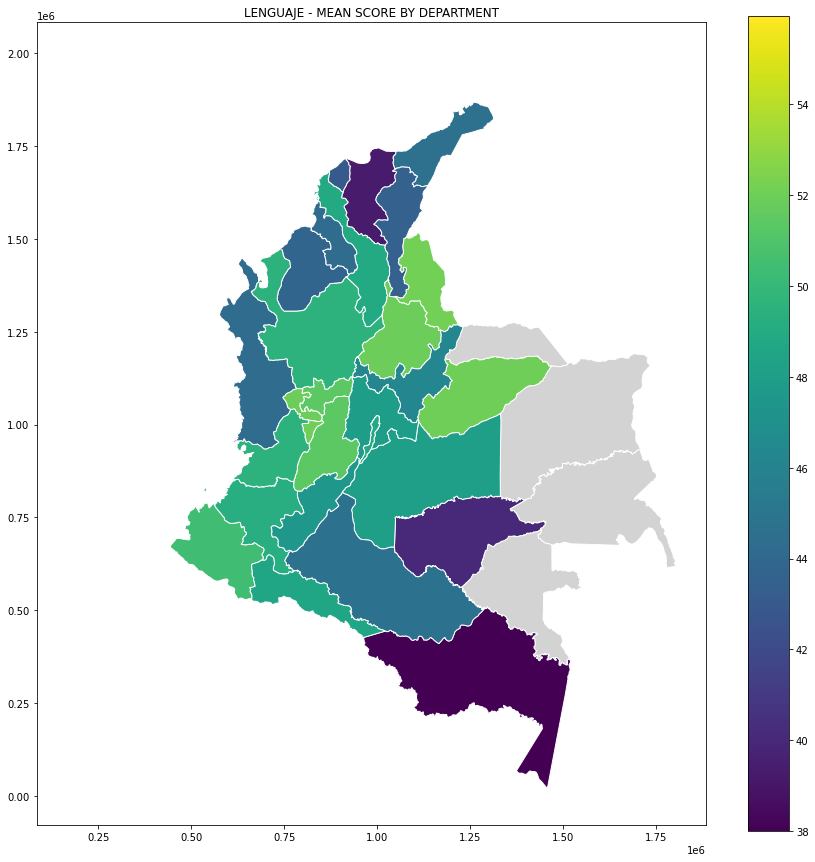

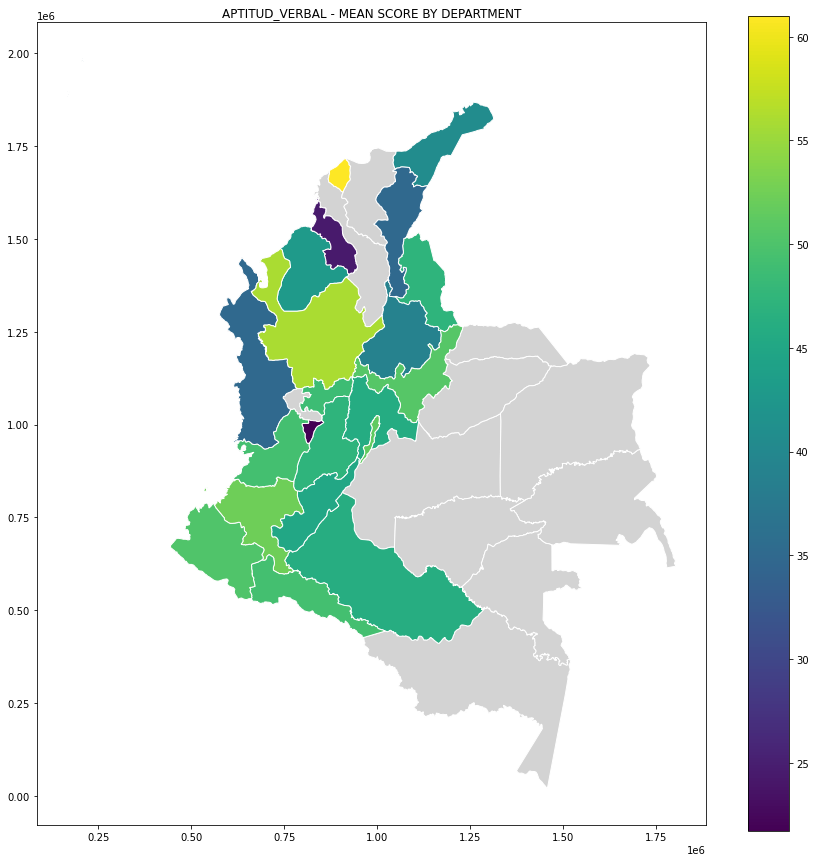

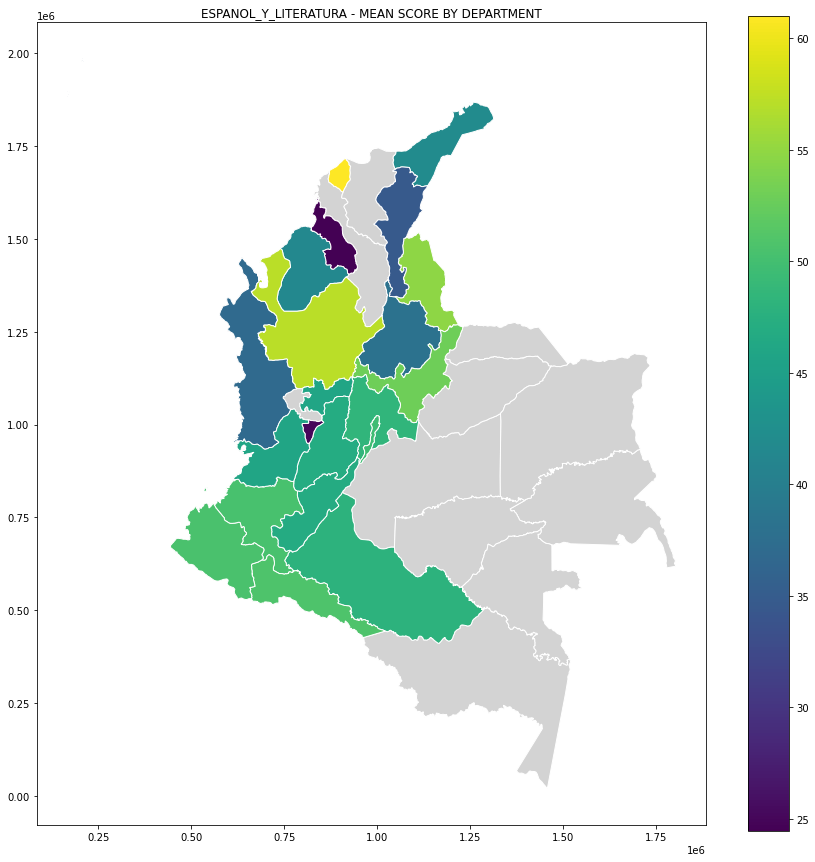

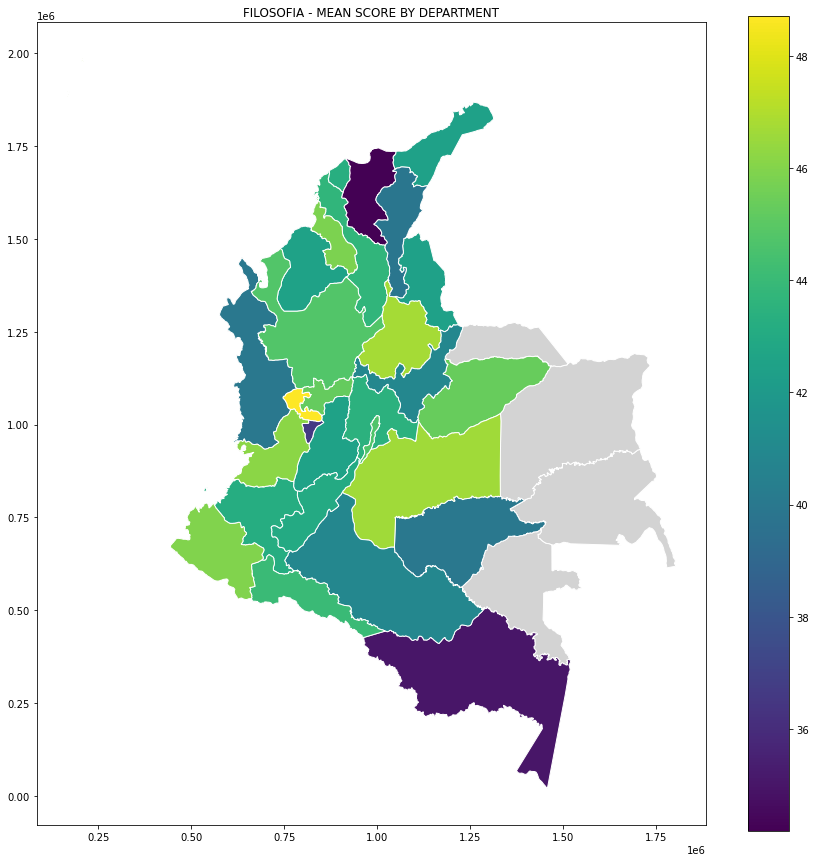

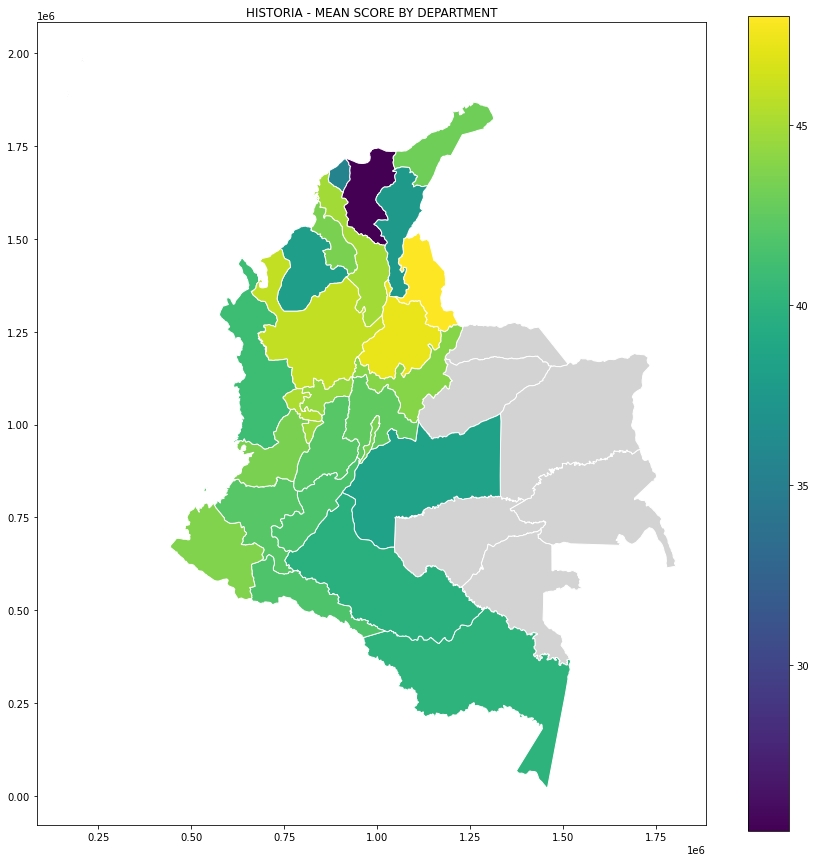

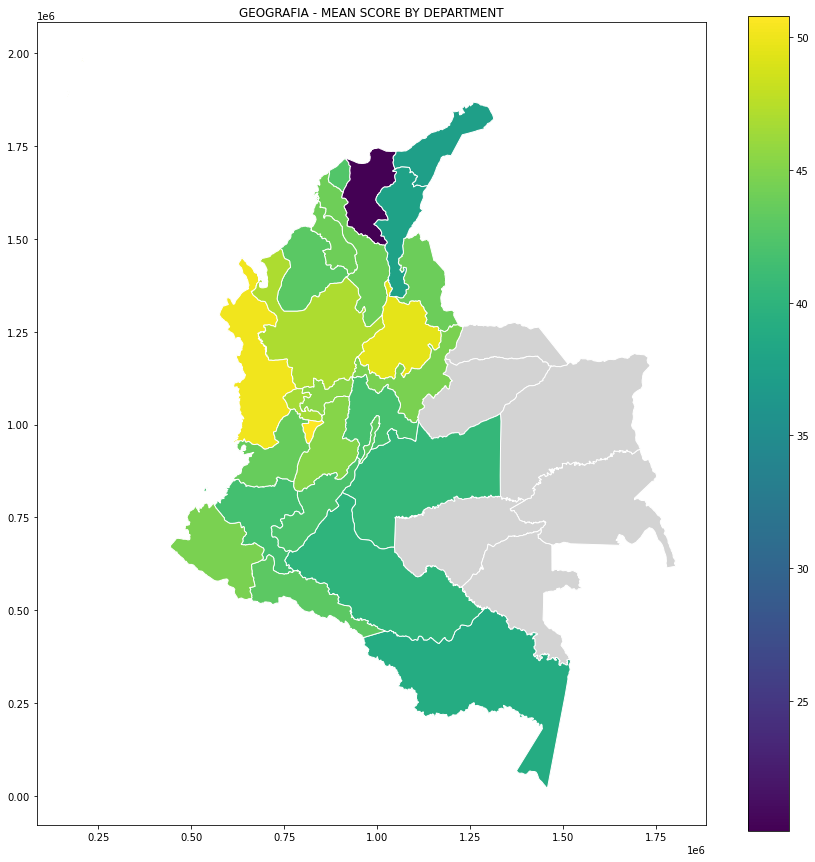

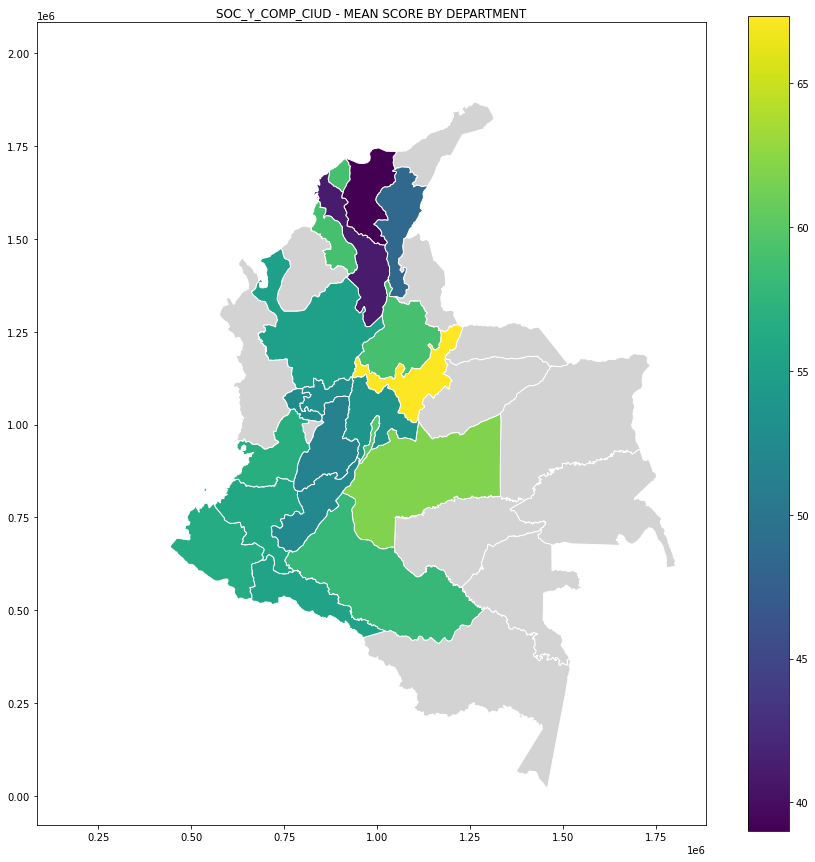

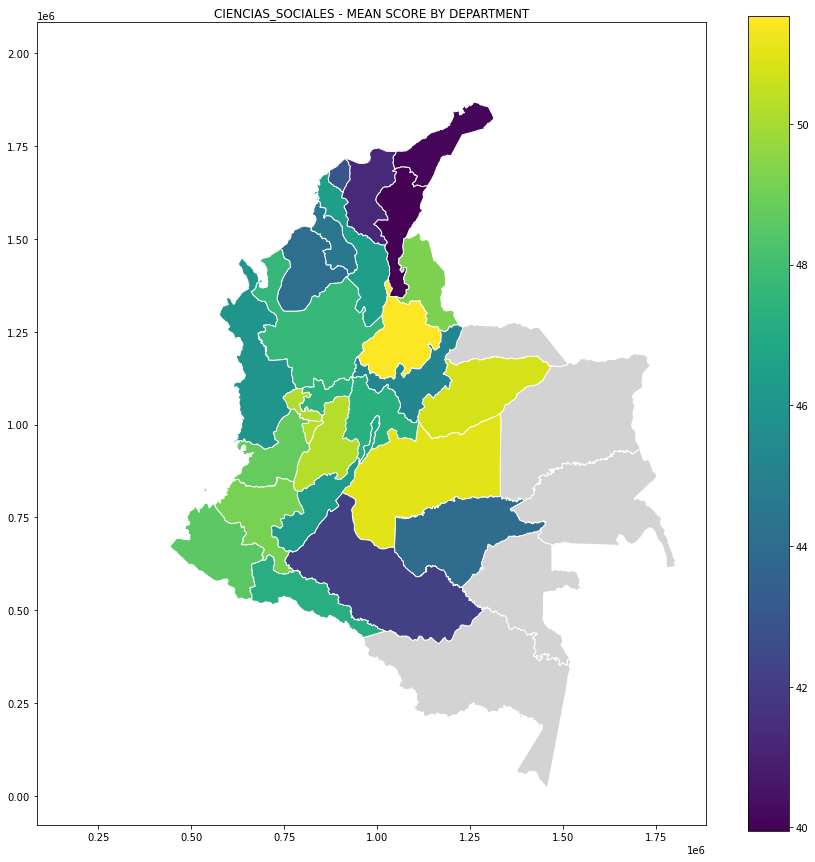

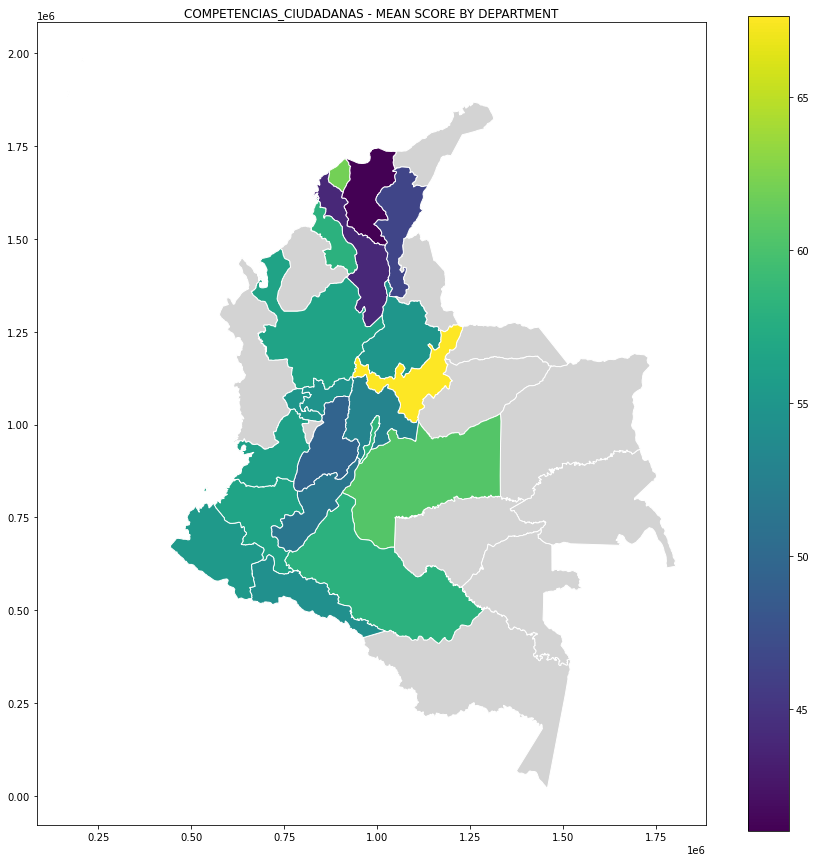

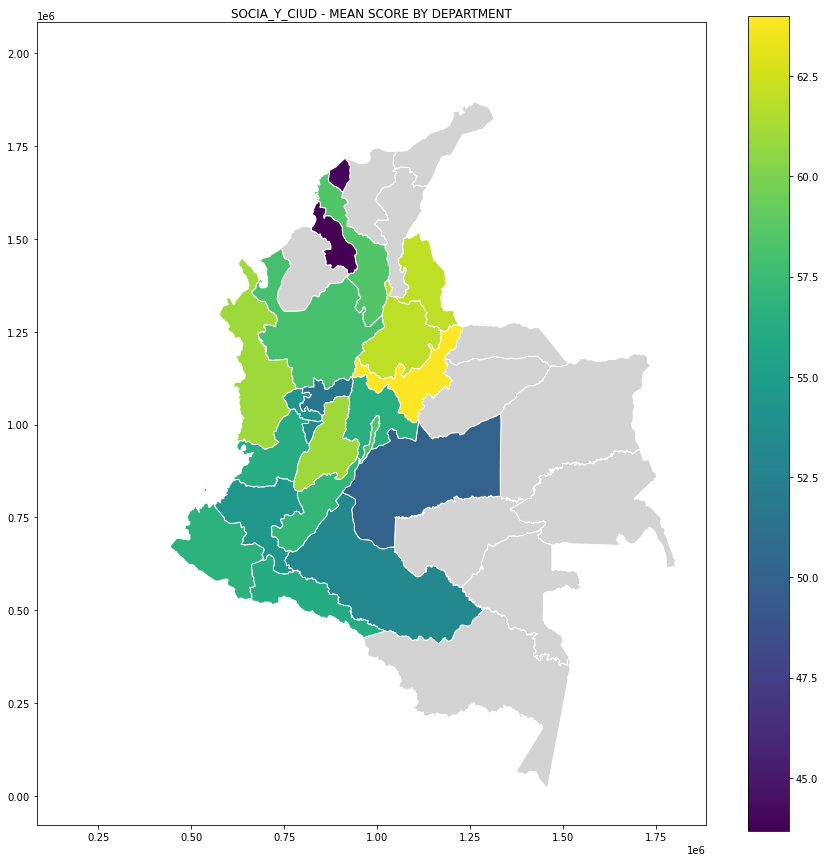

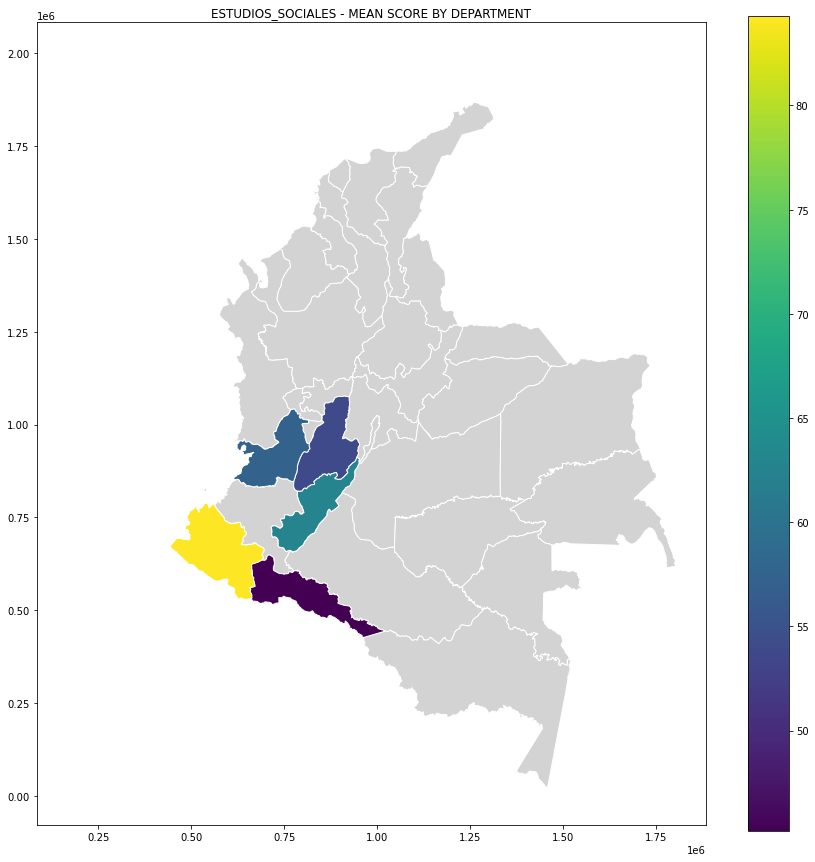

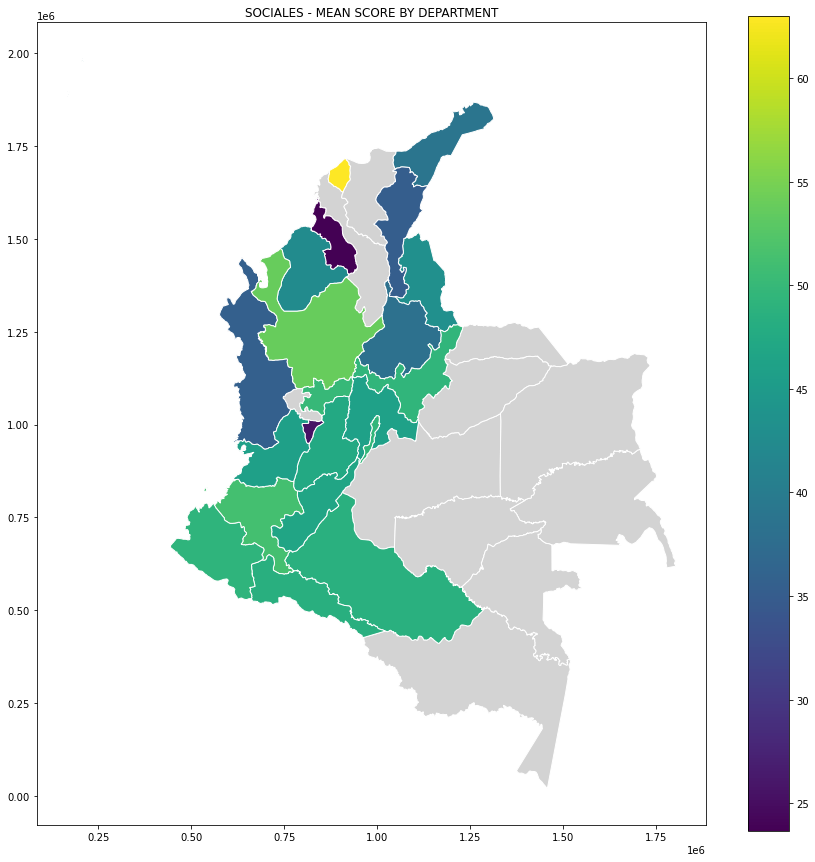

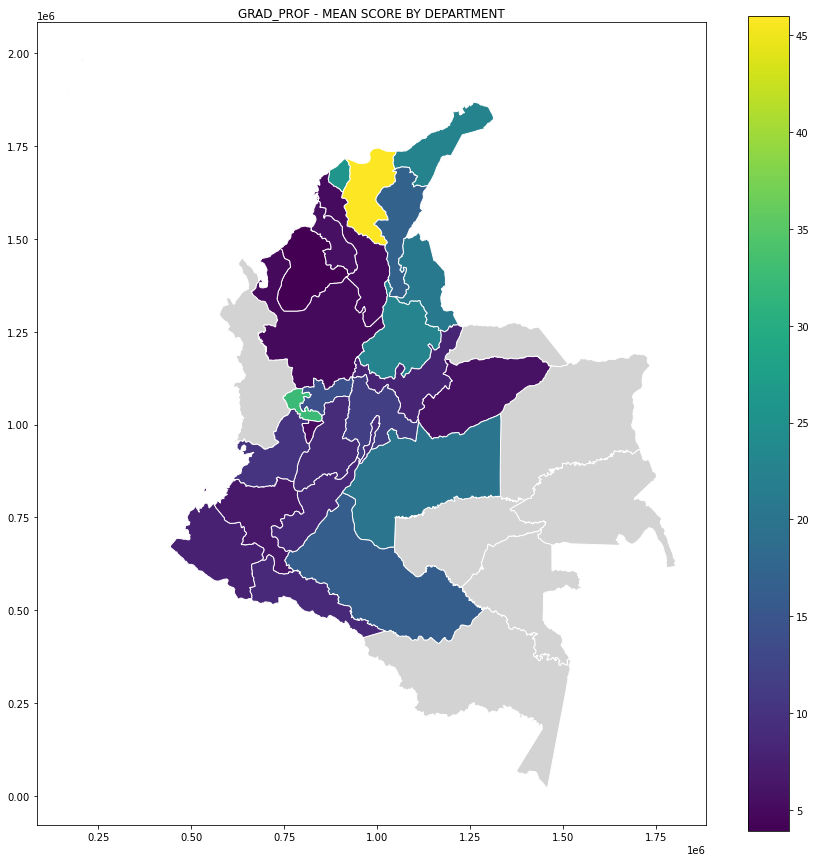

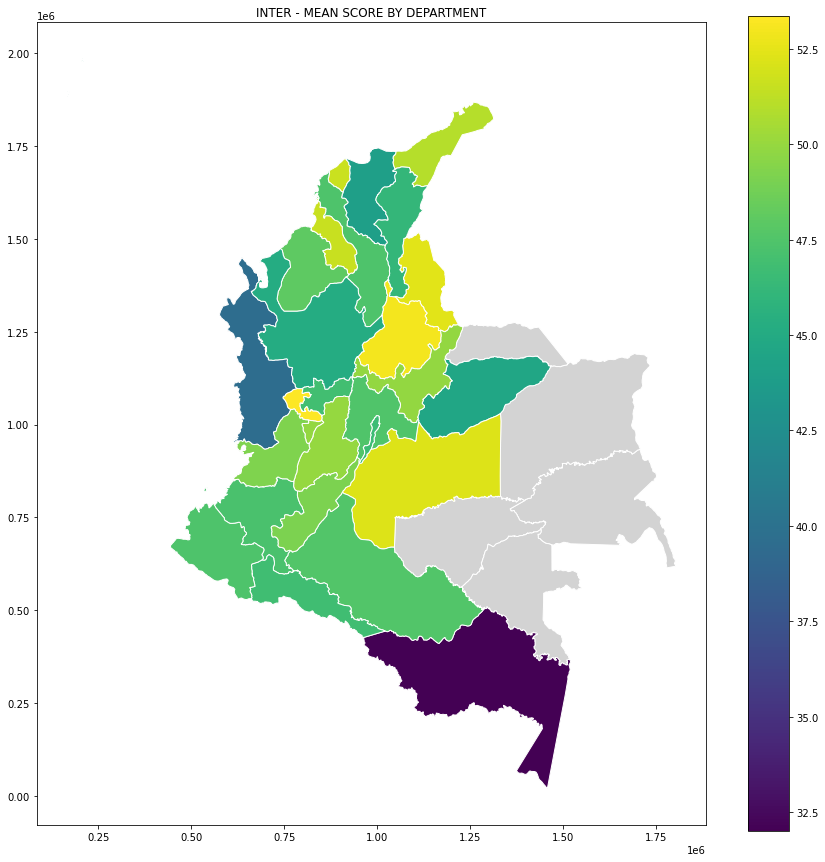

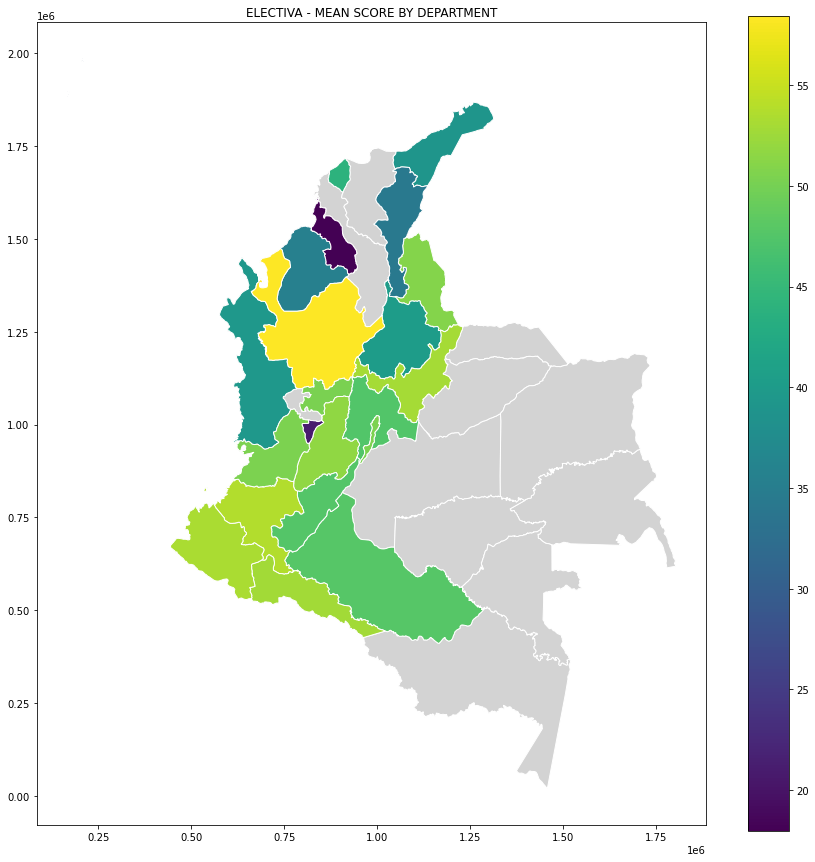

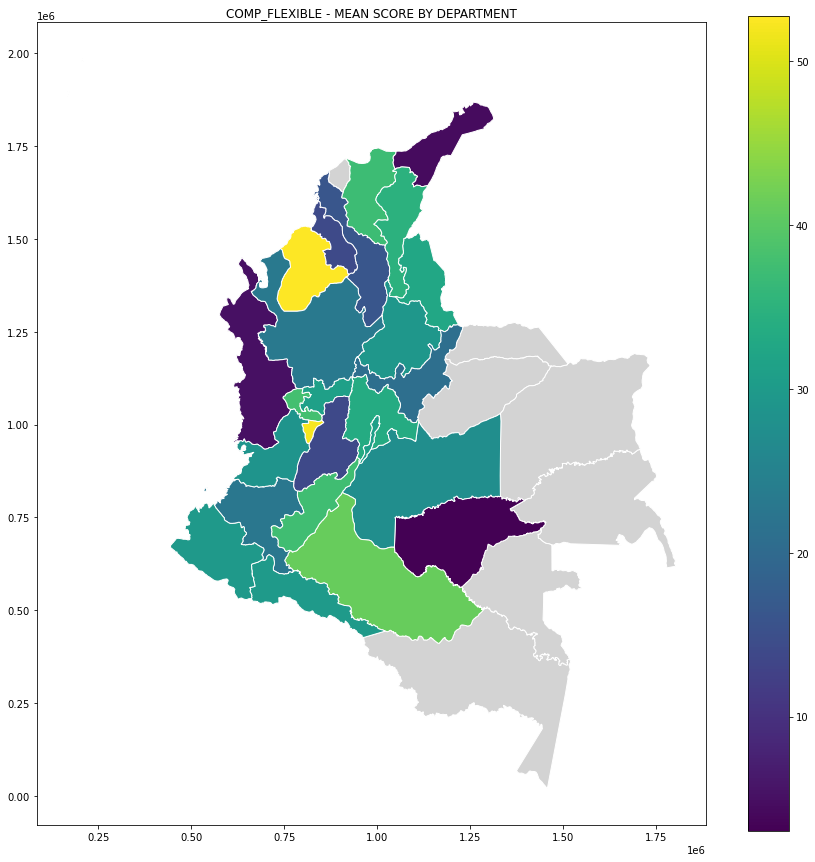

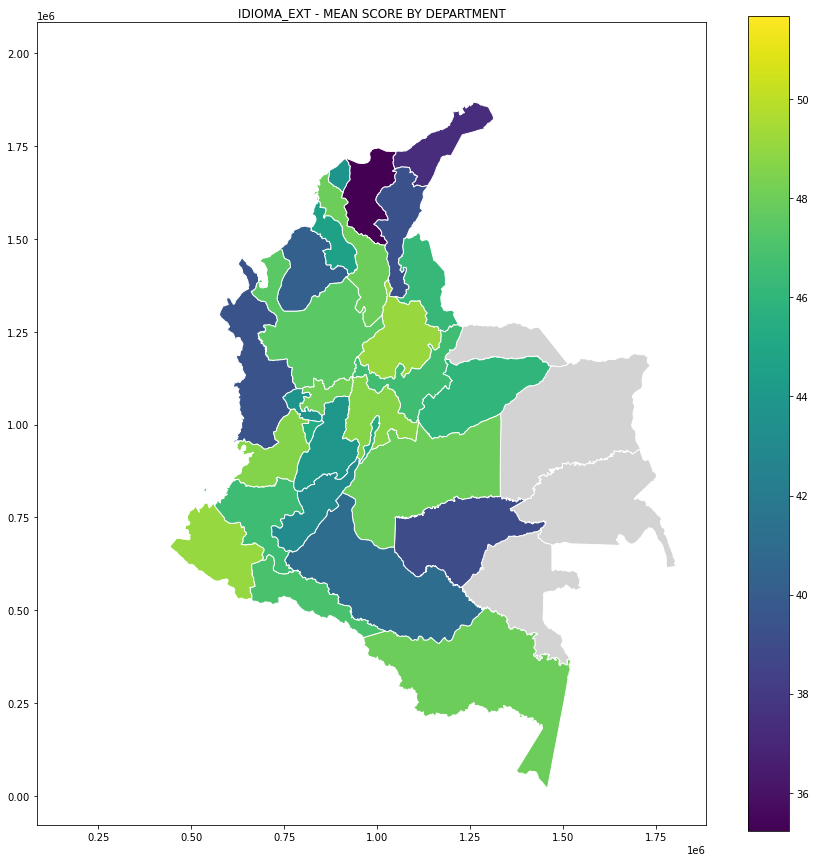

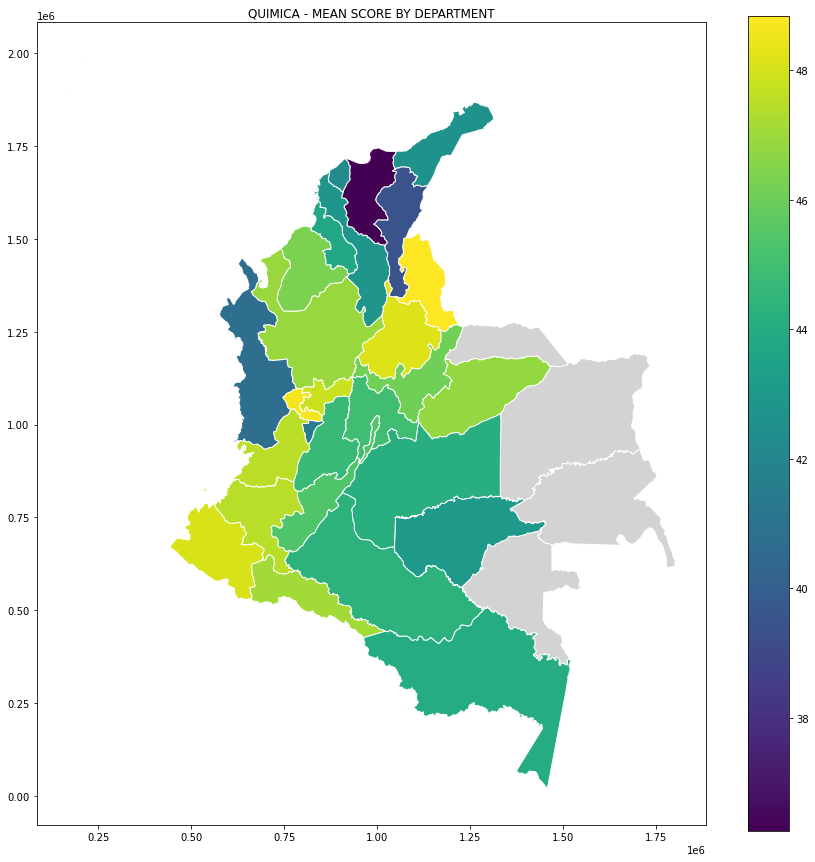

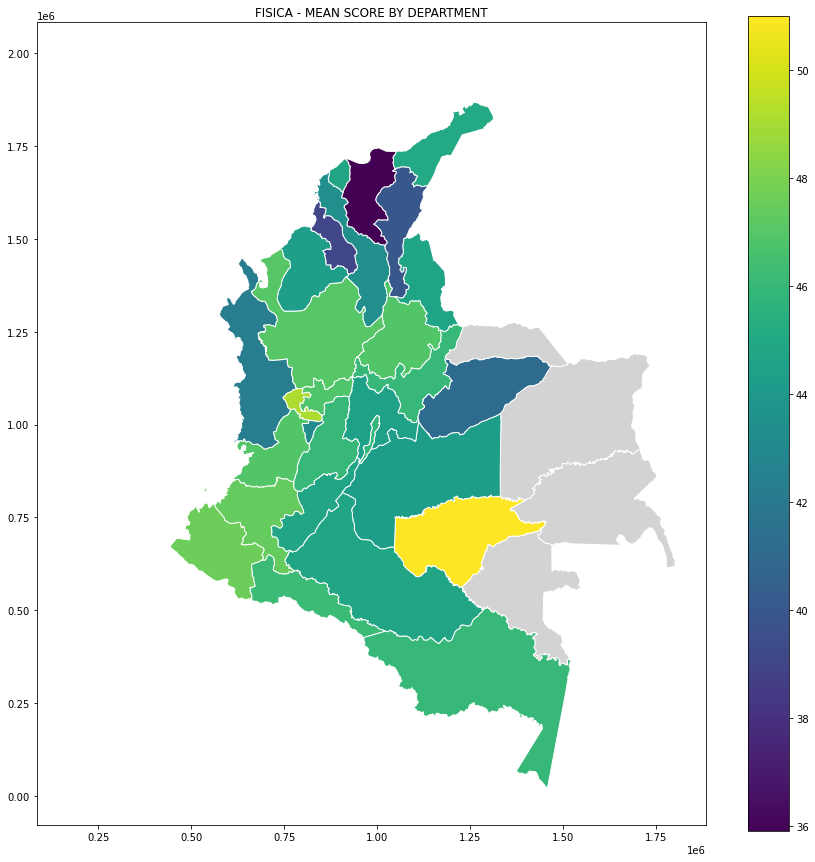

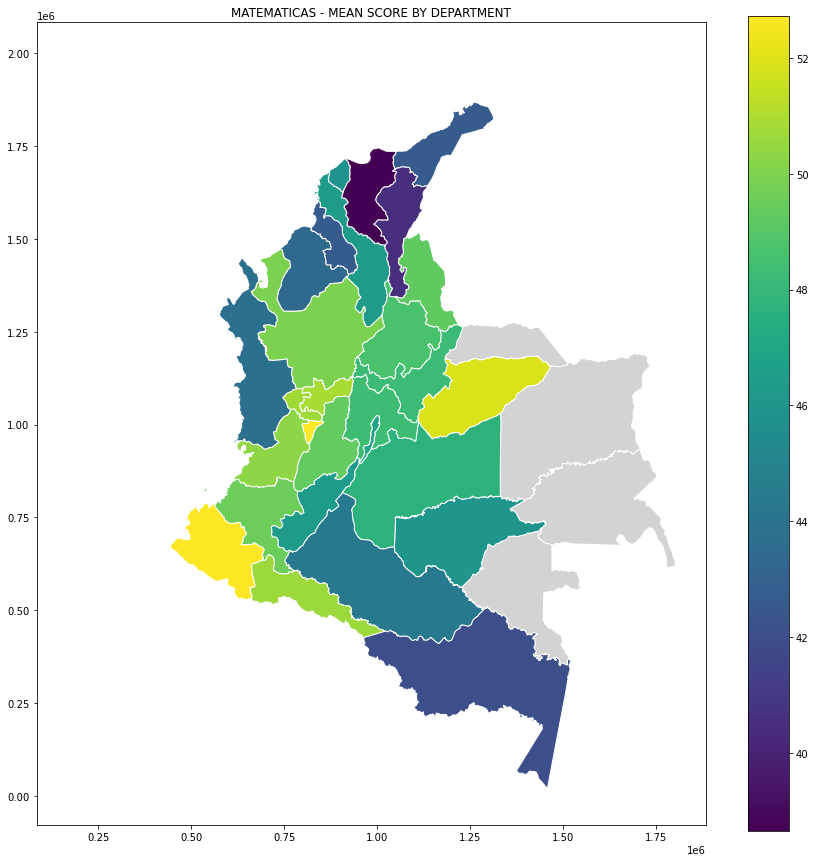

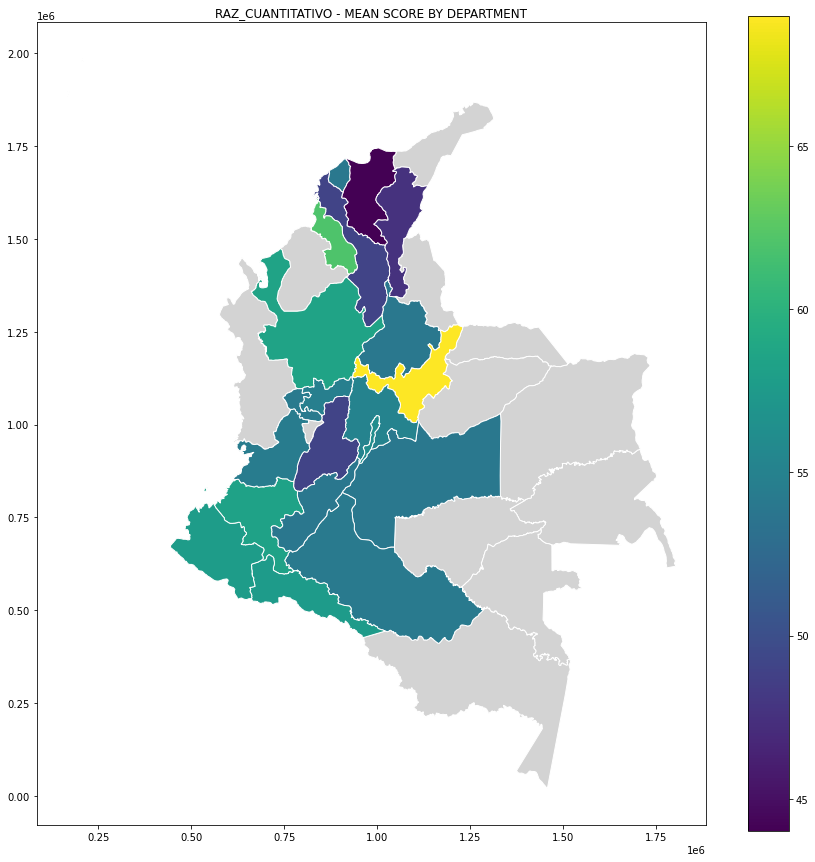

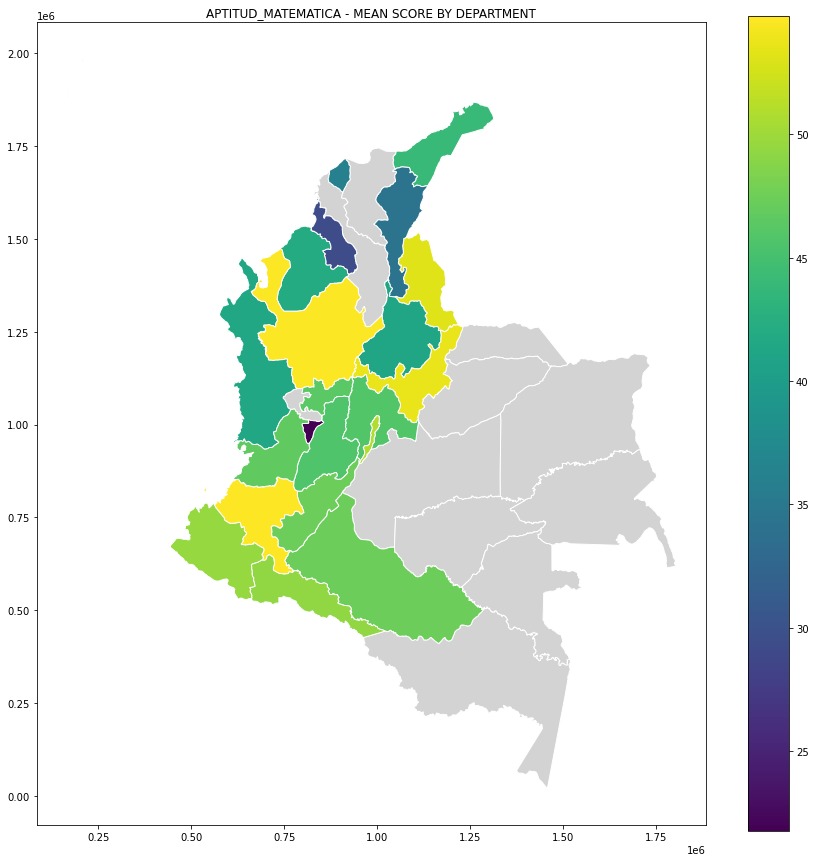

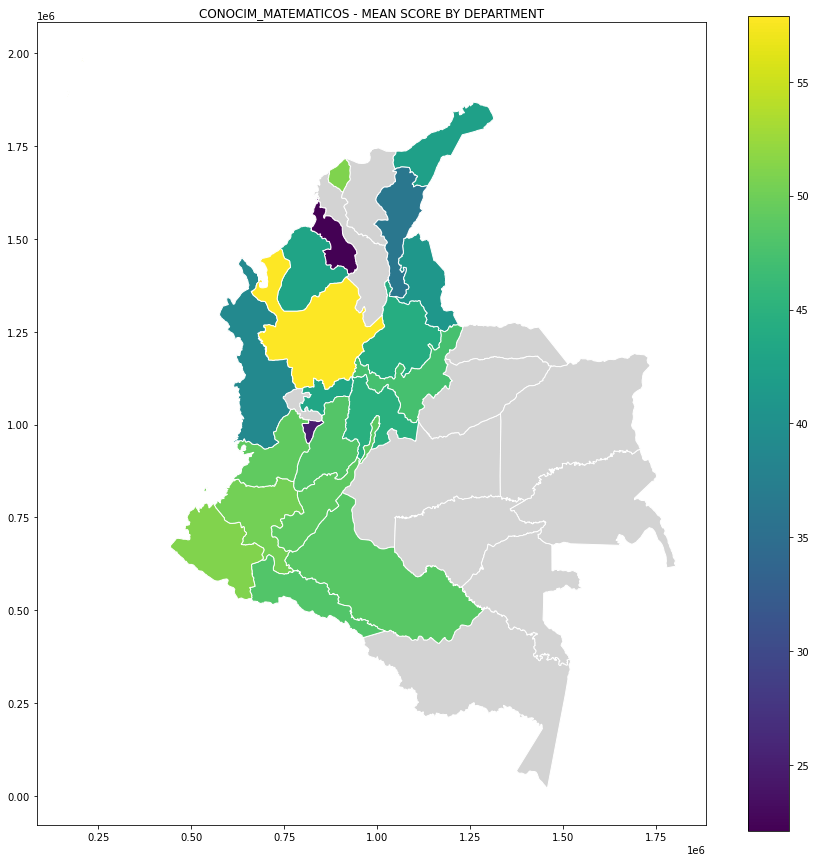

In [51]:
for course in courses:
    plot_map(course, 'viridis')

Export the combined shapefile for next step in the investigation:

In [63]:
geodata.to_file("geodata.gpkg", driver="GPKG")